[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# 具备消息总结与外部数据库记忆的聊天机器人

## 回顾

我们已经讲过如何自定义图的状态（state）模式以及 reducer（归约器）。

也展示了多种在图状态中裁剪或过滤消息的技巧。

我们用这些概念实现过一个带记忆的聊天机器人，它会生成对话的滚动摘要。

## 目标

但是，如果我们希望聊天机器人拥有“可以无限期持久化”的记忆怎么办？

现在，我们将引入一些更高级的检查点（checkpointer），它们支持外部数据库。

这里我们展示如何使用 [Sqlite 作为 checkpointer](https://docs.langchain.com/oss/python/langgraph/persistence#checkpointer-libraries)，当然还可以选择 Postgres 等其他实现！

In [26]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [27]:
import os
from pathlib import Path
from dotenv import load_dotenv
from rich import print as rprint

# 获取项目根目录（当前文件所在目录的上一级）
project_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
env_path = project_root / '.env'

# 加载 .env 文件
load_dotenv(dotenv_path=env_path)

required_vars = ['OPENAI_API_KEY', 'OPENAI_API_BASE', 'MODEL_NAME', "LANGSMITH_API_KEY", "LANGSMITH_TRACING", "LANGSMITH_PROJECT"]
missing_vars = [var for var in required_vars if not os.environ.get(var)]

if missing_vars:
    rprint(f"[red]警告: 以下环境变量未在 .env 文件中配置: {', '.join(missing_vars)}[/red]")
else:
    rprint(f"[green]✓ 环境变量已从 {env_path} 成功加载[/green]")

✓ 环境变量已从 /home/ruoshui/Documents/MyProject/agent/langchain-academy-learning/.env 成功加载

## Sqlite

一个好的起步方式是使用 [SqliteSaver checkpointer](https://docs.langchain.com/oss/python/langgraph/persistence#checkpointer-libraries)。

Sqlite 是一个[小巧、快速、非常流行](https://x.com/karpathy/status/1819490455664685297)的 SQL 数据库。

如果我们提供 `":memory:"`，它会创建一个内存中的 Sqlite 数据库。

In [28]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

但是，如果我们提供一个数据库路径，它就会为我们创建一个真正的数据库文件！

In [29]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [30]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

## 定义一个聊天机器人。

```text
开始
  ↓
call_model (生成回复)
  ↓
should_continue (判断)
  ├─→ 消息 ≤ 6 → END
  └─→ 消息 > 6 → summarize_conversation
                    ├─ 生成/扩展摘要
                    ├─ 删除旧消息(保留最近2条)
                    └→ END
```
核心是Messagestate，详情见[graph](https://docs.langchain.com/oss/python/langgraph/graph-api)

由于在应用程序中存储消息列表非常普遍，因此存在一个预定义的状态结构（`MessagesState`），它能够方便地管理消息。`MessagesState`通过一个名为 `messages` 的键来存储消息，该键是一个 `AnyMessage` 对象的列表，并使用 `add_messages` 减法器（reducer）来处理消息的添加。

`message`字段：
`messages: Annotated[list[AnyMessage], add_messages]`

总共四种消息类型：
| 消息类型 | 说明 | 角色标识 | 使用场景 |
|---------|------|---------|---------|
| **`HumanMessage`** | 用户消息 | `role="human"` 或 `"user"` | 用户输入、问题 |
| **`AIMessage`** | AI 助手消息 | `role="assistant"` 或 `"ai"` | LLM 生成的回复 |
| **`SystemMessage`** | 系统消息 | `role="system"` | 系统提示词、上下文说明 |
| **`ToolMessage`** | 工具调用结果 | `role="tool"` | 工具执行后返回的数据 |

所有消息类型都继承自 `BaseMessage`，包含：
```python
class BaseMessage:
    content: str | list[dict]  # 消息内容（文本或多模态）
    id: str | None            # 唯一标识符
    name: str | None          # 可选名称
    additional_kwargs: dict   # 额外的元数据
    response_metadata: dict   # 响应元数据（如 token 使用量）
```


In [38]:
from typing_extensions import Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState


model = ChatOpenAI(model=os.environ.get("MODEL_NAME"),temperature=0)

# state状态继承来Messagestate
# 拥有了一个新的str字段，这个字段是一个摘要

class State(MessagesState):
    summary: str

# 调用逻辑
def call_model(state: State):

    summary = state.get("summary", "")

    if summary:
        
        system_message = f"Summary of conversation earlier: {summary}"

        # 把摘要添加到新上下文，append方式添加，追加
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

# 摘要扩展
def summarize_conversation(state: State):
    
    summary = state.get("summary", "")
    if summary:
        
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # 仅仅保留最新的message，n = 2 
    # 
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# 条件路由
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize_conversation"
    
    return END

现在，我们只需要用刚才的 sqlite checkpointer 重新编译即可。

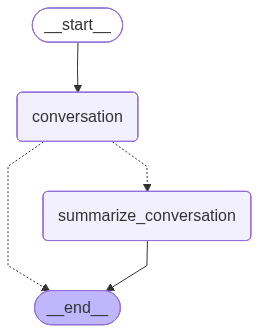

In [39]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START


workflow = StateGraph(State)

# 执行call_model函数调用的节点
workflow.add_node("conversation", call_model)

# 执行对话摘要总结函数调用
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")

# 由should_continue函数的返回值确定图走向 
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

现在，我们可以多次调用这个图。

In [ ]:
config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the footballs!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()


# 由于设置的限制是6条消息，下面的对话会触发摘要节点
# 所以整个路径走向是：
# START → conversation → summarize_conversation → END

input_message = HumanMessage(content="who do i like?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! Good to see you again — and yes, we know you're a 49ers fan too! 😄

Since you've mentioned both your name and your team a few times now, is there something specific you'd like to chat about? Maybe a favorite player, a game you'll never forget, or your hopes for this season?
================================== Ai Message ==================================

Your name is Lance! 😊
================================== Ai Message ==================================

That's awesome, Lance! I'm glad you like football — and since you're a 49ers fan, you've got great taste in teams! 🏈

Are you talking about the 49ers' style of play, a favorite game, or just football in general?
================================== Ai Message ==================================

You like the San Francisco 49ers! 🏈❤️💛

You've mentioned that a few times now. They're a great team with a lot of history. Want to talk about your favori

我们来确认一下状态确实被保存在本地。

In [41]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='f5e2057f-120e-4841-9d70-f7e8f2d22afa'), AIMessage(content="Hi Lance! Good to see you again — and yes, we know you're a 49ers fan too! 😄\n\nSince you've mentioned both your name and your team a few times now, is there something specific you'd like to chat about? Maybe a favorite player, a game you'll never forget, or your hopes for this season?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 483, 'total_tokens': 554, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'deepseek-ai/DeepSeek-V3.2-Exp', 'system_fingerprint': '', 'id': '019ab4d4fac41a1f113b2f4dc60d4860', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--fca42849-5f9

### 状态持久化

使用 Sqlite 这样的数据库意味着状态是持久化的！

例如：我们可以重启 notebook 的内核，然后仍然可以从磁盘上的 Sqlite 数据库加载之前的状态。

In [42]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='f5e2057f-120e-4841-9d70-f7e8f2d22afa'), AIMessage(content="Hi Lance! Good to see you again — and yes, we know you're a 49ers fan too! 😄\n\nSince you've mentioned both your name and your team a few times now, is there something specific you'd like to chat about? Maybe a favorite player, a game you'll never forget, or your hopes for this season?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 483, 'total_tokens': 554, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'deepseek-ai/DeepSeek-V3.2-Exp', 'system_fingerprint': '', 'id': '019ab4d4fac41a1f113b2f4dc60d4860', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--fca42849-5f9

## Studio

**⚠️ 注意**

自录制这些视频以来，我们已更新 Studio，使其现在可以在本地运行并通过浏览器访问。这是替代视频中所示桌面应用（Desktop App）的首选运行方式。它现在被称为 _LangSmith Studio_，而不是之前的 _LangGraph Studio_。详细的设置说明在课程开头的 “Getting Setup” 指南中。你可以在[这里](https://docs.langchain.com/langsmith/studio)找到 Studio 的描述，本地部署的具体细节在[这里](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server)。  
要启动本地开发服务器，请在本模块的 `/studio` 目录中运行：

```
langgraph dev
```

你应当看到如下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

在浏览器中打开上面显示的 **Studio UI** URL。
加载 Studio 中的 `chatbot`，它使用 `module-2/studio/chatbot.py`，并在 `module-2/studio/langgraph.json` 中进行了配置。